In [1]:
# Import necessary libraries for data handling, model utilization, and visualization
import numpy as np
import pandas as pd
import yfinance as yf  # For collecting financial data
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Tuple
from scipy.optimize import minimize 
from datetime import datetime, timedelta
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from collections import deque
# Import the custom Model class
from Model import Model

# Set the random seed for reproducibility across numpy and tensorflow
np.random.seed(123)

plt.style.use('seaborn-darkgrid')

# Define the tickers and date range with consideration of trading days
TICKERS = ['AGG','DBC','VTI','^VIX']

# Approximate number of trading days per year (useful for annualizing returns)
TRADING_DAYS_PER_YEAR = 252

# Confirm setup
print("Setup complete: libraries imported, random seed set, and tickers defined.")


Setup complete: libraries imported, random seed set, and tickers defined.


C:\Users\wiztu\AppData\Local\Temp\ipykernel_21324\1997288386.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
# Data Collection Step
# Objective: Fetch historical adjusted close prices for defined tickers and date range

# Download data using yfinance for the specified tickers and date range
def get_data(tickers, start_date, end_date):
    """
    Retrieves historical adjusted close prices for the given tickers and date range.
    
    Parameters:
    - tickers: List of stock ticker symbols
    - start_date: Start date for historical data
    - end_date: End date for historical data
    
    Returns:
    - DataFrame of adjusted close prices, with each column representing a ticker
    """
    # Fetch data from yfinance
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    
    # Drop rows with missing values, if any, to ensure data continuity
    data.dropna(inplace=True)
    
    return data

# Fetch the data and display a quick preview
data = get_data(TICKERS, '2000-01-01', '2021-01-04')
print("Data fetched successfully. Sample data:")
print(data.head())

# Confirm data spans the expected range and has the expected number of columns
print(f"Data covers {len(data)} trading days with {len(data.columns)} assets.")


[*********************100%%**********************]  4 of 4 completed

Data fetched successfully. Sample data:
Ticker            AGG        DBC        VTI   ^VIX
Date                                              
2006-02-06  56.300117  20.889498  44.654274  13.04
2006-02-07  56.260818  20.285255  44.219490  13.59
2006-02-08  56.232700  20.198933  44.537624  12.83
2006-02-09  56.266441  20.388840  44.452793  13.12
2006-02-10  56.148415  20.017662  44.544693  12.87
Data covers 3753 trading days with 4 assets.


In [3]:
def calculate_annualized_volatility(price_data):
    log_returns = np.log(price_data / price_data.shift(1))
    daily_volatility = log_returns.std()
    annualized_volatility = daily_volatility * np.sqrt(TRADING_DAYS_PER_YEAR)
    return annualized_volatility

In [4]:
def determine_target_volatility(ticker, start_date, end_date, percentage_of_benchmark=0.8):
    price_data = get_data(ticker, start_date, end_date)
    benchmark_volatility = calculate_annualized_volatility(price_data)
    if isinstance(benchmark_volatility, pd.Series):
        benchmark_volatility = benchmark_volatility.iloc[0]
        
    target_volatility = benchmark_volatility * percentage_of_benchmark
    return ticker, benchmark_volatility * 100, target_volatility * 100

In [5]:
volatility_data = []

for ticker in TICKERS:
    ticker, benchmark_vol, target_vol = determine_target_volatility(ticker, '2010-01-01', '2020-01-01', 0.8)
    volatility_data.append({
        'Ticker': ticker,
        'Benchmark Volatility (%)': benchmark_vol,
        'Target Volatility (%)': target_vol
    })

volatility_df = pd.DataFrame(volatility_data)
volatility_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Ticker,Benchmark Volatility (%),Target Volatility (%)
0,AGG,3.235561,2.588449
1,DBC,15.687099,12.549679
2,VTI,15.029547,12.023637
3,^VIX,122.819360,98.255488


In [6]:
def preprocess_data(data, rolling_window=50):
    """
    Prepares data by calculating 50-day rolling averages and returns.

    Parameters:
    - data: DataFrame of historical adjusted close prices for assets
    - rolling_window: Window size for the rolling average

    Returns:
    - normalized_data: Smoothed prices, normalized to start at 1 for each asset
    - returns: Smoothed returns using a rolling mean of percentage changes
    """
    # Calculate rolling mean for prices and returns to smooth the data
    smoothed_prices = (data.rolling(window=rolling_window).mean()).dropna()
    smoothed_returns = (data.pct_change().rolling(window=rolling_window).mean()).dropna()
    # Normalize prices to start each asset's time series at 1
    normalized_data = smoothed_prices / smoothed_prices.iloc[0]
    
    return normalized_data, smoothed_returns


# Run preprocessing and display sample data
normalized_data, smoothed_returns = preprocess_data(data)
print("Data preprocessing complete. Sample normalized data:")
print(normalized_data.head())
print("\nSample daily returns:")
print(smoothed_returns.head())


Data preprocessing complete. Sample normalized data:
Ticker           AGG       DBC       VTI      ^VIX
Date                                              
2006-04-18  1.000000  1.000000  1.000000  1.000000
2006-04-19  0.999786  1.001443  1.000798  0.997130
2006-04-20  0.999555  1.003226  1.001815  0.993875
2006-04-21  0.999332  1.005552  1.002683  0.991806
2006-04-24  0.999172  1.007249  1.003528  0.989520

Sample daily returns:
Ticker           AGG       DBC       VTI      ^VIX
Date                                              
2006-04-19 -0.000212  0.001441  0.000813 -0.001952
2006-04-20 -0.000229  0.001788  0.001035 -0.002230
2006-04-21 -0.000221  0.002295  0.000882 -0.001198
2006-04-24 -0.000157  0.001709  0.000862 -0.001374
2006-04-25 -0.000182  0.002136  0.000757 -0.000993


In [7]:
class Portfolio:
    def __init__(self, initial_cash: float, assets: pd.DataFrame):
        """
        Initializes the Portfolio object.

        Parameters:
        - initial_cash: The starting value of the portfolio in cash.
        - assets: DataFrame of asset prices (historical data).
        """
        self.initial_cash = initial_cash
        self.current_value = initial_cash
        self.assets = assets  # Historical price data for the assets
        self.weights = np.zeros(len(assets.columns))  # Initialize weights as zero
        self.portfolio_history = []  # To track portfolio value over time
        self.rebalancing_dates = []  # To store rebalancing dates

    def rebalance(self, new_weights: np.array, target_volatility = None):
        """
        Rebalances the portfolio according to new weights.

        Parameters:
        - new_weights: Numpy array of asset allocations.
        """
        if len(new_weights) != len(self.assets.columns):
            raise ValueError("Number of weights must match the number of assets.")
        self.weights = new_weights
        if target_volatility is not None:
            self.volatility_scaling(target_volatility=target_volatility, lambda_decay=0.94)

    def calculate_initial_shares(self, initial_cash, initial_prices):
        """
        Calculates the number of shares for each asset at the start of the testing period based on
        initial cash and allocation weights.

        Parameters:
        - initial_cash: The starting cash value of the portfolio.

        Returns:
        - shares: Dictionary with tickers as keys and the initial number of shares as values.
        """
        # Calculate the dollar amount allocated to each asset
        dollar_allocation = initial_cash * self.weights

        # Calculate the number of shares for each asset
        shares = (dollar_allocation // initial_prices).astype(int)  # Floor division to get whole shares

        # Return as a dictionary for easy readability
        return dict(zip(self.assets.columns, shares))
    
    def calculate_daily_returns(self):
        """
        Applies the current weights to asset returns and updates portfolio value over time.
        """
        # Calculate daily returns for each asset
        daily_returns = self.assets.pct_change().dropna()
        
        # Calculate portfolio returns by applying weights
        portfolio_returns = np.dot(daily_returns, self.weights)

        # Track the portfolio's value over time by compounding the returns
        for daily_ret in portfolio_returns:
            self.current_value *= (1 + daily_ret)
            self.portfolio_history.append(self.current_value)

    def update_portfolio_value(self, date):
        """
        Updates the portfolio value for a single date.
        """
        # Get the index of the date
        date_index = self.assets.index.get_loc(date)
        if date_index == 0:
            # First day, no previous day to compute return
            self.portfolio_history.append(self.current_value)
            return
        # Get the asset returns for that day
        previous_date = self.assets.index[date_index - 1]
        daily_return = self.assets.loc[date] / self.assets.loc[previous_date] - 1
        # Calculate portfolio return
        portfolio_return = np.dot(daily_return.values, self.weights)
        # Update portfolio value
        self.current_value *= (1 + portfolio_return)
        # Append to history
        self.portfolio_history.append(self.current_value)


    def track_portfolio_performance(self):
        """
        Tracks and prints the portfolio performance over time.
        """
        for date, value in zip(self.assets.index[1:], self.portfolio_history):
            print(f"Date: {date}, Portfolio Value: {value}")
    
    def reset(self):
        self.current_cash = self.initial_cash
        self.assets = self.initial_assets.copy()
        self.weights = np.zeros(len(self.assets.columns))  # Reset to no investments
        self.portfolio_history = []
        self.rebalancing_dates = []
        return self.assets.iloc[0].values

    def get_portfolio_value(self):
        """
        Returns the current value of the portfolio.
        """
        return self.current_value
    
    def plot_portfolio_value(self):
        """
        Plots the portfolio value over time.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.assets.index[1:], self.portfolio_history, label="Portfolio Value")
        plt.title("Portfolio Value Over Time")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value")
        plt.legend()
        plt.show()

    def apply_volatility_scaling(self, target_volatility=0.1, rolling_window=50):
        """
        Scales portfolio allocations based on the ratio of target volatility to current asset volatilities.
        
        Parameters:
        - target_volatility: The target annualized volatility for the portfolio (e.g., 0.1 for 10%).
        - rolling_window: The window size (in days) for calculating each asset's rolling volatility.
        
        Returns:
        - Scaled weights to achieve the target volatility for each asset.
        """
        # Calculate daily returns of the portfolio assets
        daily_returns = self.assets.pct_change().dropna()
        
        # Calculate rolling volatility (annualized) for each asset over the rolling window
        asset_volatilities = daily_returns.rolling(window=rolling_window).std().iloc[-1] * np.sqrt(252)
        asset_volatilities = asset_volatilities.dropna()
        
        # Compute scaling factor for each asset to achieve the target volatility
        scaling_factors = target_volatility / asset_volatilities

        # Scale weights by the scaling factors
        self.weights = self.weights * scaling_factors

        # Normalize weights to ensure they sum to 1
        self.weights = self.weights / np.sum(self.weights)

        # Debugging: Print intermediate values to verify calculations
        print(f"Asset Volatilities: {asset_volatilities}")
        print(f"Scaling Factors: {scaling_factors}")
        print(f"Scaled and Normalized Weights: {self.weights}")
        
        return self.weights  # Return the scaled weights
    
    def volatility_scaling(self, target_volatility=0.10, lambda_decay=0.94):

        daily_returns = self.assets.pct_change().dropna()
        ewma_volatility = daily_returns.ewm(alpha=1-lambda_decay, adjust=False).std()
        
        current_volatility = ewma_volatility.iloc[-1]
        
        scaling_factors = target_volatility / current_volatility
        
        new_weights = self.weights * scaling_factors
        
        adjusted_weights = new_weights / np.sum(new_weights)
        
        return adjusted_weights


In [8]:
def train_and_rebalance_portfolio(portfolio: Portfolio, model: Model):
    """
    Trains the LSTM model once over the full dataset and returns a single set of allocation weights.

    Parameters:
    - portfolio: An instance of the Portfolio class.
    - model: An instance of the Model class for training.
    
    Returns:
    - allocations: Final optimized weights for each asset in the portfolio.
    """
    # Use the entire dataset for training
    train_data = portfolio.assets

    # Get allocations from the model
    allocations = model.get_allocations(train_data)

    # Rebalance the portfolio with the optimized weights (if needed for tracking)
    portfolio.rebalance(allocations)

    # Return the final allocation weights
    return allocations


In [9]:
def calculate_metrics(portfolio_values):
    """
    Calculates performance metrics for the portfolio.

    Parameters:
    - portfolio_values: List of daily portfolio values over the testing period.

    Returns:
    - metrics: Dictionary containing Sharpe Ratio, Sortino Ratio, and Max Drawdown.
    """
    # Convert portfolio values to daily returns
    portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Calculate Sharpe Ratio
    mean_return = np.mean(portfolio_returns)
    std_dev = np.std(portfolio_returns)
    sharpe_ratio = mean_return / std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Sortino Ratio
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std_dev = np.std(downside_returns)
    sortino_ratio = mean_return / downside_std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Maximum Drawdown
    cumulative_returns = np.maximum.accumulate(portfolio_values) - portfolio_values
    max_drawdown = np.max(cumulative_returns / np.maximum.accumulate(portfolio_values))
    
    return {
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown
    }

In [10]:
def equal_weighted_strategy(returns):
    """
    Creates an equal-weighted portfolio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - equal_weights: Numpy array of equal weights for each asset.
    """
    num_assets = returns.shape[1]
    equal_weights = np.ones(num_assets) / num_assets
    return equal_weights

def mean_variance_optimized_strategy(returns):
    """
    Creates a mean-variance optimized portfolio by maximizing the Sharpe Ratio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimized_weights: Numpy array of optimized weights for each asset.
    """
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    def neg_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -portfolio_return / portfolio_std

    # Constraints: Weights must sum to 1, and each weight must be between 0 and 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))

    result = minimize(neg_sharpe, np.ones(returns.shape[1]) / returns.shape[1], bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    
    return optimized_weights

def maximum_diversification(returns):
    """
    Perform maximum diversification optimization based on the given returns.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimal_weights: Array of portfolio weights that maximize diversification.
    """
    # Calculate asset volatilities (standard deviation of each asset’s returns)
    asset_volatilities = returns.std()

    # Calculate the covariance matrix of returns
    cov_matrix = returns.cov()

    # Define the diversification ratio to be maximized
    def neg_diversification_ratio(weights):
        # Calculate the weighted average asset volatility
        weighted_volatility = np.dot(weights, asset_volatilities)
        
        # Calculate the portfolio volatility as the weighted covariance matrix
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        # Diversification ratio (we negate this because we want to maximize it)
        diversification_ratio = weighted_volatility / portfolio_volatility
        return -diversification_ratio  # Negate to turn this into a minimization problem

    # Constraints: weights sum to 1, and each weight between 0 and 1 (long-only portfolio)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(asset_volatilities)))

    # Initial guess (equal allocation)
    init_guess = np.ones(len(asset_volatilities)) / len(asset_volatilities)

    # Optimize to find weights that maximize diversification ratio
    result = minimize(neg_diversification_ratio, init_guess, bounds=bounds, constraints=constraints)
    optimal_weights = result.x
    
    return optimal_weights


In [11]:
def generalized_rolling_validation(data, allocation_strategy, train_years=2, test_months=12, initial_cash=100000):
    results = []
    final_values = []

    # Use the raw data's indices for consistent date ranges
    dates = data.index
    total_periods = len(dates)
    period_length = test_months * 21  # Approximate trading days in test_months
    start_idx = 0

    while True:
        train_end_idx = start_idx + train_years * 252  # Approximate trading days in train_years
        test_start_idx = train_end_idx + 1
        test_end_idx = test_start_idx + period_length

        # Break if we don't have enough data left
        if test_end_idx >= total_periods:
            break

        # Define date ranges using indices
        train_data = data.iloc[start_idx:train_end_idx]
        test_data = data.iloc[test_start_idx:test_end_idx]

        # Preprocess data for non-LSTM strategies
        if allocation_strategy != train_and_rebalance_portfolio:
            _, train_returns = preprocess_data(train_data)
            _, test_returns = preprocess_data(test_data)
            final_allocations = allocation_strategy(train_returns)
        else:
            # For LSTM, use raw train_data
            model = Model()
            training_portfolio = Portfolio(initial_cash=initial_cash, assets=train_data)
            final_allocations = allocation_strategy(training_portfolio, model=model)

        # Initialize testing portfolio with raw test_data
        testing_portfolio = Portfolio(initial_cash=initial_cash, assets=test_data)
        testing_portfolio.rebalance(final_allocations)
        testing_portfolio.calculate_daily_returns()
        final_values.append(testing_portfolio.get_portfolio_value())

        # Calculate performance metrics
        metrics = calculate_metrics(testing_portfolio.portfolio_history)

        # Store results
        results.append({
            'train_period': (dates[start_idx], dates[train_end_idx]),
            'test_period': (dates[test_start_idx], dates[test_end_idx]),
            'metrics': metrics
        })

        # Plot the portfolio value over time for this roll
        testing_portfolio.plot_portfolio_value()

        # Move to the next period
        start_idx += period_length

    return results, final_values


[*********************100%%**********************]  4 of 4 completed


Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: -0.1151
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -0.1534
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1714
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.2477
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1975
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.2390
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1689
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.2095
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1861
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.2092
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1894
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1854
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1930
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.2558
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1771
Epoch 16/100
8/8

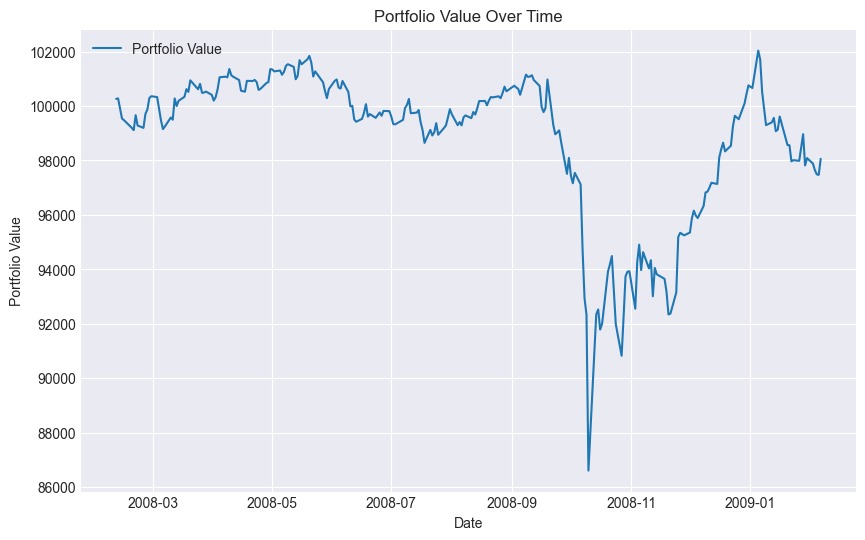

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0318
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0476
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: -0.0502
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -0.1042
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1242
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1407
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1210
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1379
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1510
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1213
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1634
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1303
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1573
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1329
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1195
Epoch 16/100
8/8 

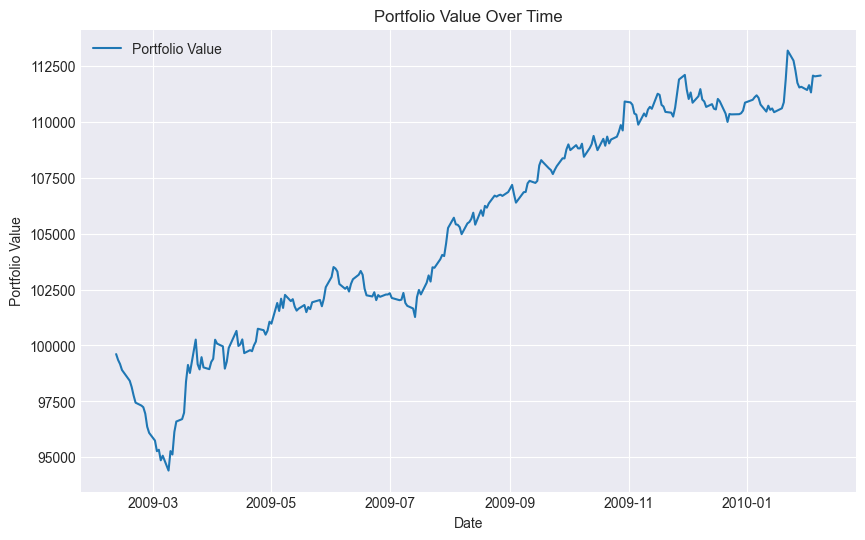

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: -0.0186
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -0.0207
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -0.0243
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: -0.0236
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: -0.0645
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -0.0607
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: -7.9434e-04
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: -0.0445
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -0.0487
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0063
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -0.0979
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -0.0706
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.0029
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -0.0853
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0511
1/1 ━━━━━━━━

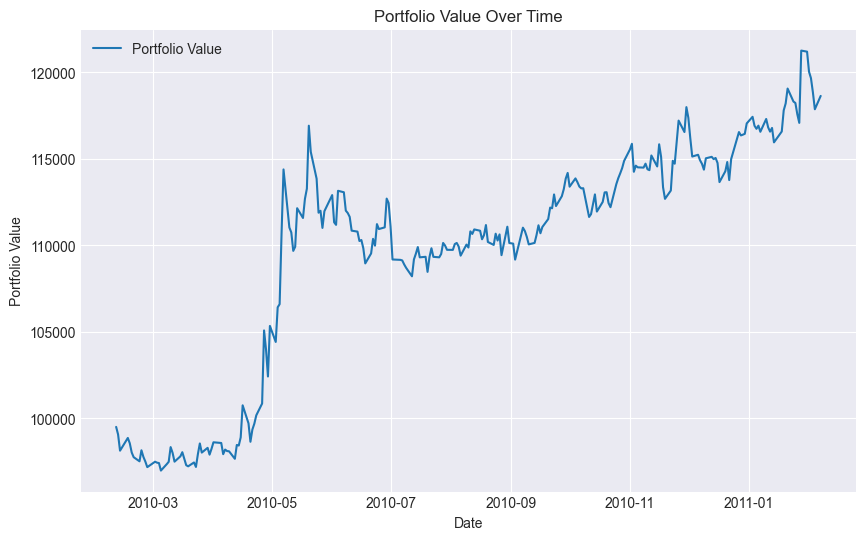

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0375
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -0.0142
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -0.0261
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0191
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: -0.0912
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: -0.0911
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -0.1233
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1979
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.2078
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.2241
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.2140
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1378
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -0.2000
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -0.1678
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1848
Epoch 16/100
8/8 ━

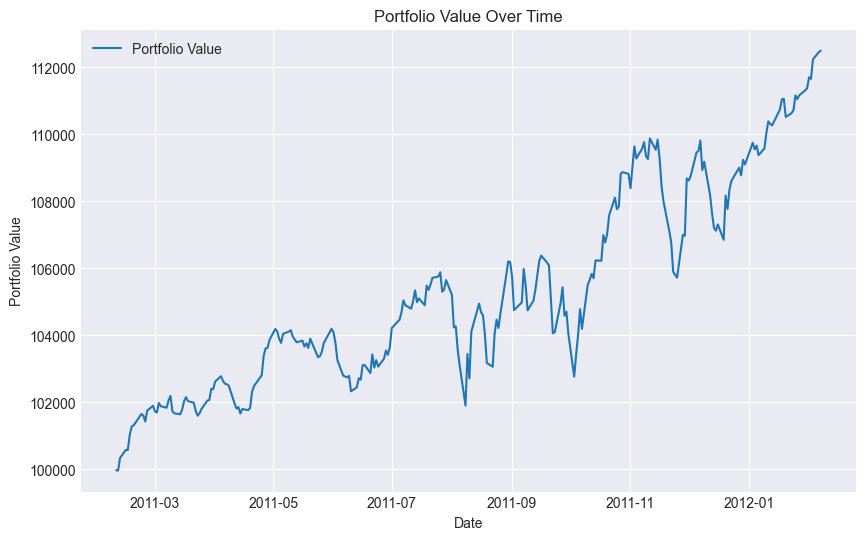

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0501
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0512
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0841
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0907
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1261
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -0.1364
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1613
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1760
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1949
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1892
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1907
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1859
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1194
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1246
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -0.1973
Epoch 16/100
8/8

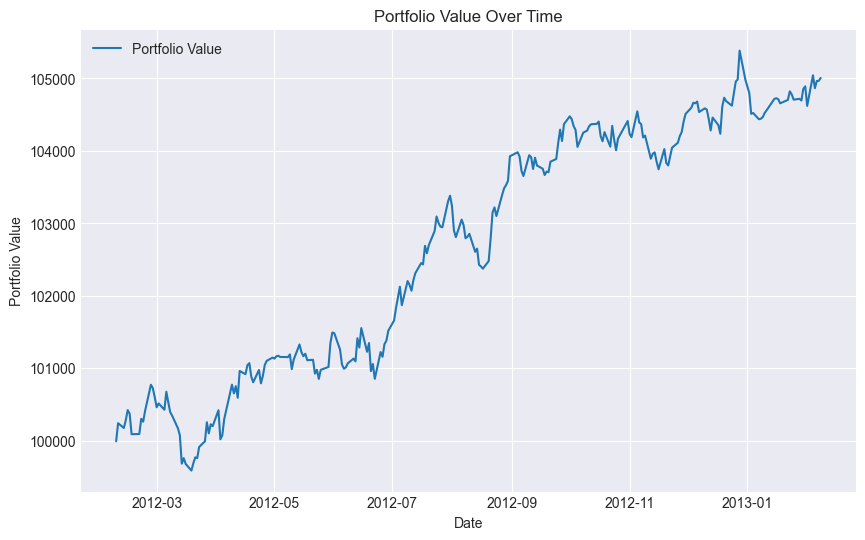

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -0.0268
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0192
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.0348
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.0453
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0594
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0348
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.0340
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0895
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0478
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1468
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0837
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1073
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.0299
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1374
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1918
Epoch 16/100
8/8 

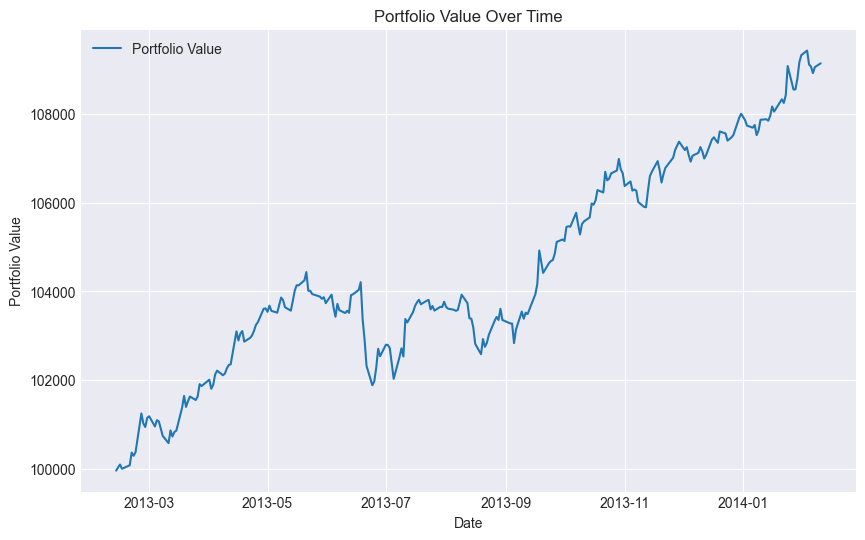

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: -0.0506
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0563   
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0631
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0684
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0476
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1322
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1720
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1475
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.2008
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1237
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1503
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.2311
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1776
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1875
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1913
Epoch 16/100


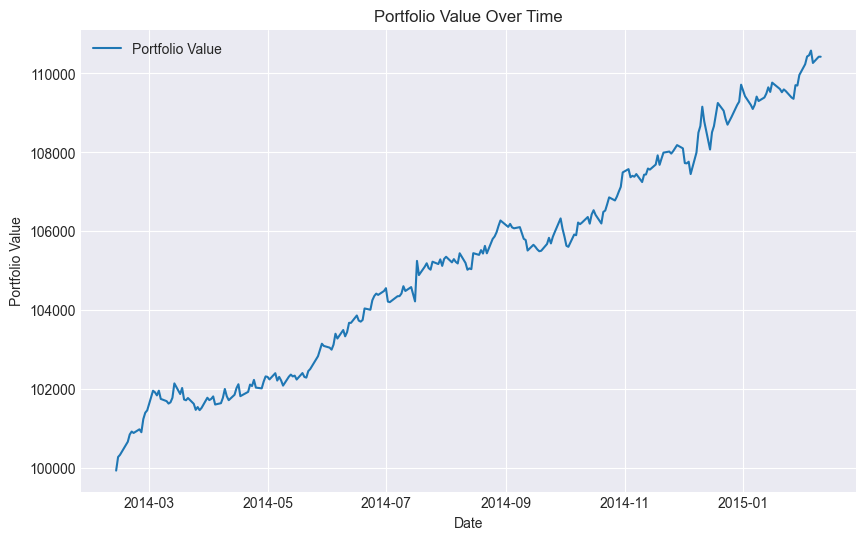

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: -0.0646
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0146
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: -0.0612
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -0.0758
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.0312
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -0.0207
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0794
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: -0.0698
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: -0.0925
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: -0.1017
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1395
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1325
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.2492
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -0.1343
Epoch 16/100
8/8 ━

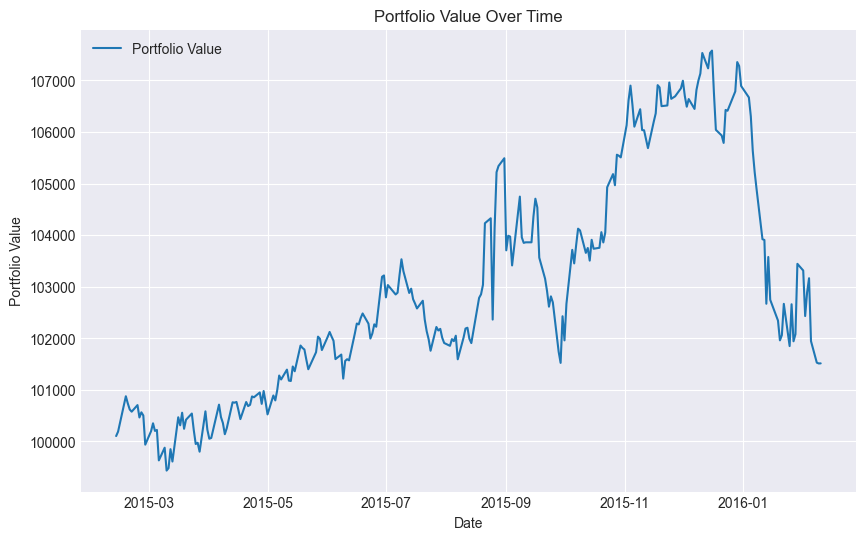

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0074
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0731
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0069
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0379
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0918
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0430
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1151
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1001
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0900
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0862
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0866
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1463
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1952
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0631
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0146
Epoch 16/100
8/8 

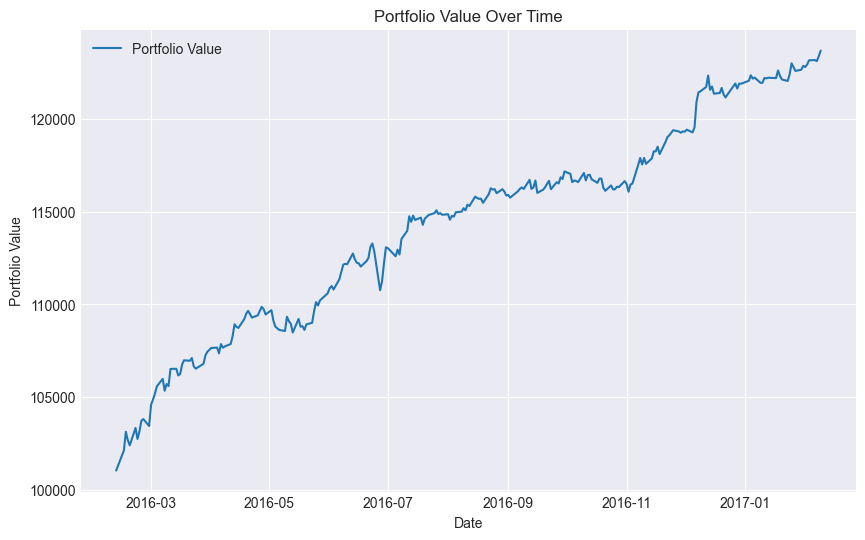

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: -0.0350
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0158
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: -0.0471
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.0842
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: -0.1190
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0987
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.0707
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1229
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1405
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0941
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.0523
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1471
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0678
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0746
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0894
Epoch 16/100
8/8

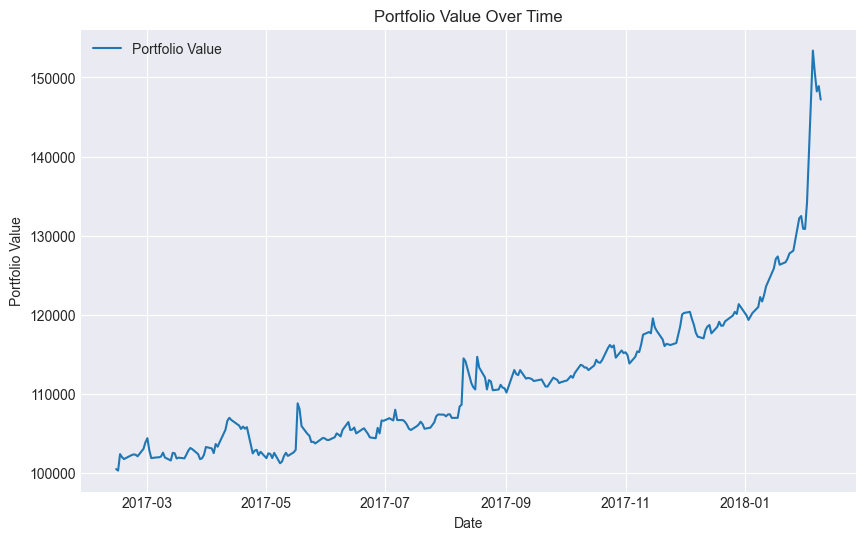

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0103
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1078
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0690
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1182
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1665
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.2051
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1737
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1808
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1510
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1762
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1675
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.2633
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.2483
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1930
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1613
Epoch 16/100
8/8

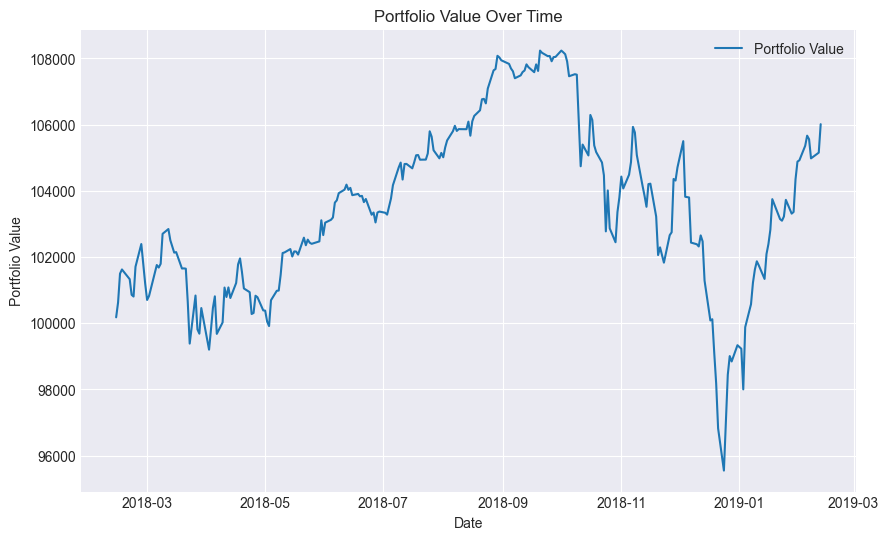

Epoch 1/100


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: -0.0477
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0579
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.0516
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0818
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.0670
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.0799
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.0664
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.2131
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1440
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.0648
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1777
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1479
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1520
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1525
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1838
Epoch 16/100
8/8

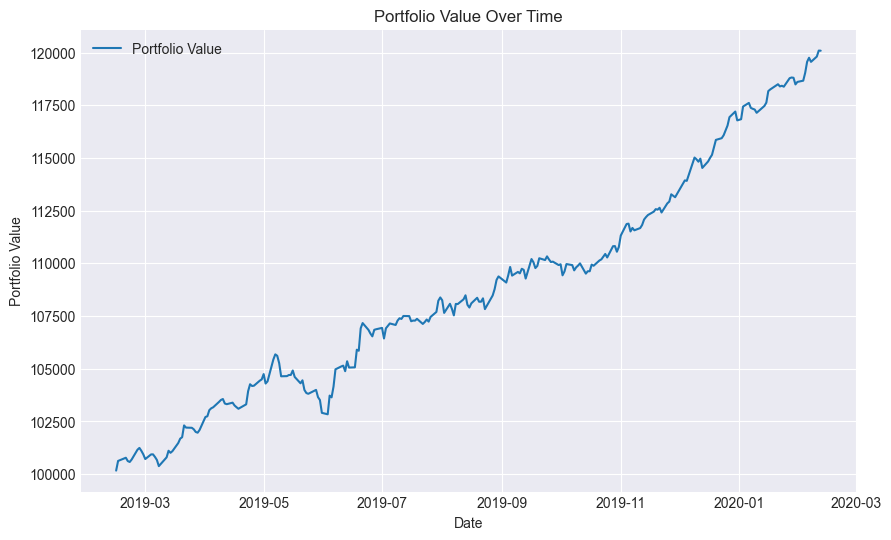

LSTM Results: [{'train_period': (Timestamp('2006-02-06 00:00:00'), Timestamp('2008-02-07 00:00:00')), 'test_period': (Timestamp('2008-02-08 00:00:00'), Timestamp('2009-02-09 00:00:00')), 'metrics': {'Sharpe Ratio': -0.1294886987132155, 'Sortino Ratio': -0.1421639126286956, 'Max Drawdown': 0.1496430054781314}}, {'train_period': (Timestamp('2007-02-07 00:00:00'), Timestamp('2009-02-06 00:00:00')), 'test_period': (Timestamp('2009-02-09 00:00:00'), Timestamp('2010-02-09 00:00:00')), 'metrics': {'Sharpe Ratio': 1.9559174817020122, 'Sortino Ratio': 3.9204544029738364, 'Max Drawdown': 0.05234079535948661}}, {'train_period': (Timestamp('2008-02-07 00:00:00'), Timestamp('2010-02-08 00:00:00')), 'test_period': (Timestamp('2010-02-09 00:00:00'), Timestamp('2011-02-08 00:00:00')), 'metrics': {'Sharpe Ratio': 1.3362296910075333, 'Sortino Ratio': 2.5769744341147662, 'Max Drawdown': 0.07443649710947074}}, {'train_period': (Timestamp('2009-02-06 00:00:00'), Timestamp('2011-02-07 00:00:00')), 'test_per

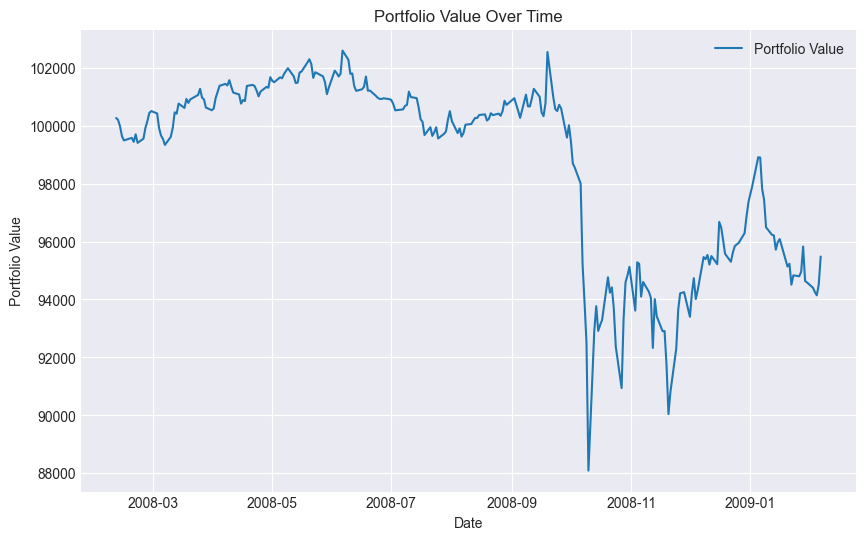

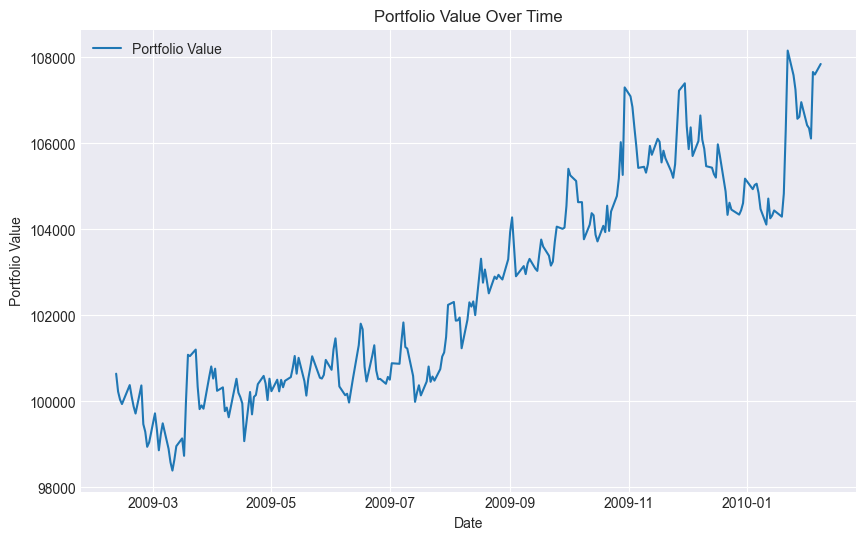

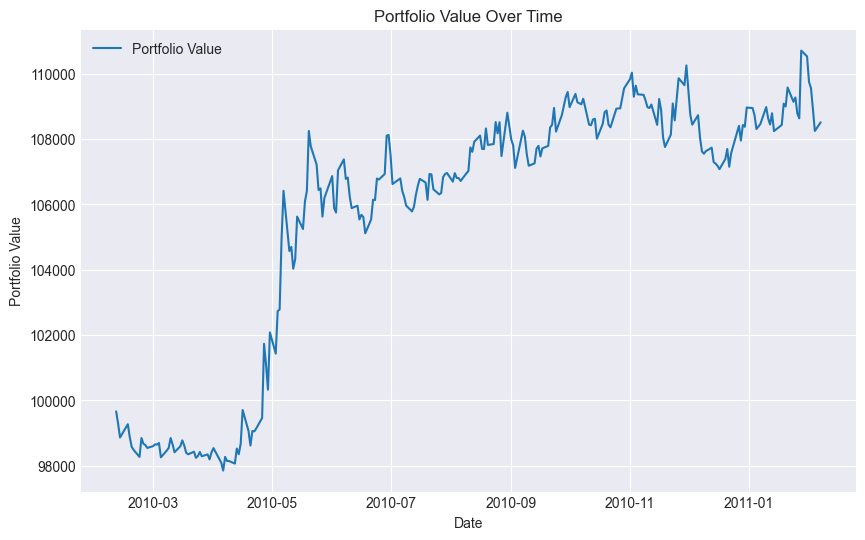

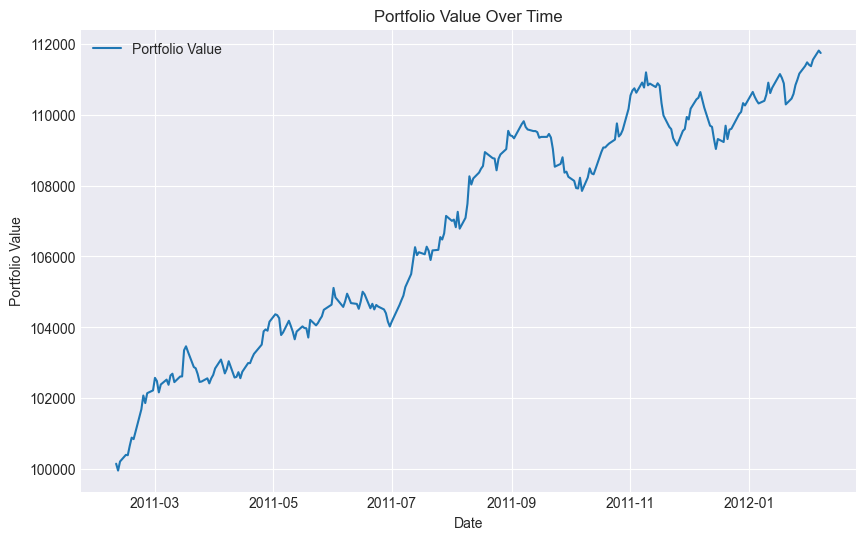

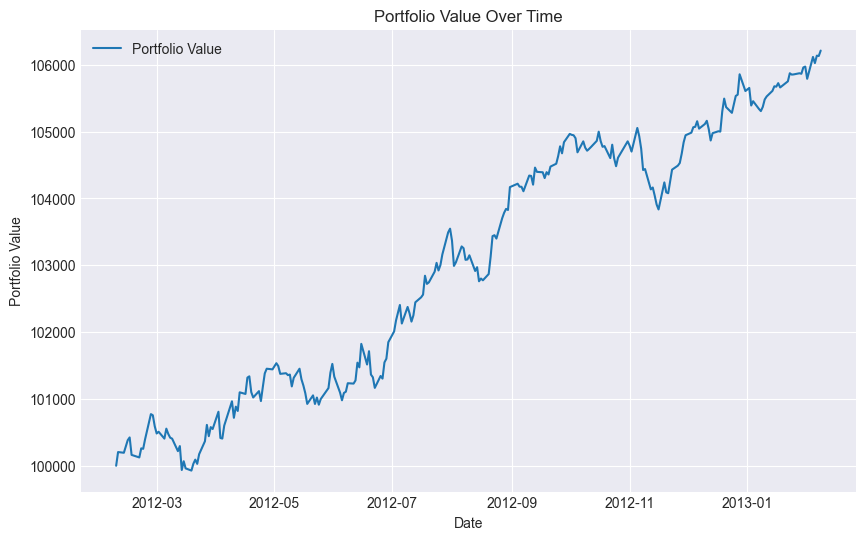

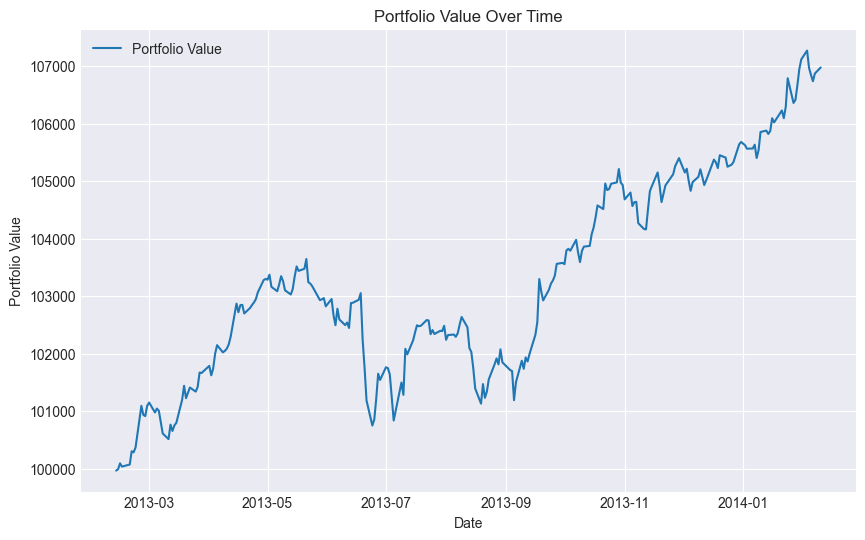

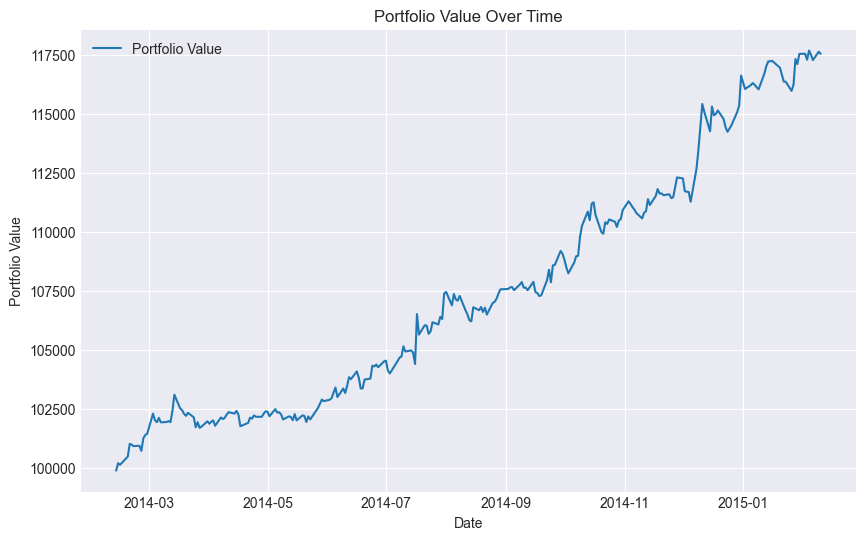

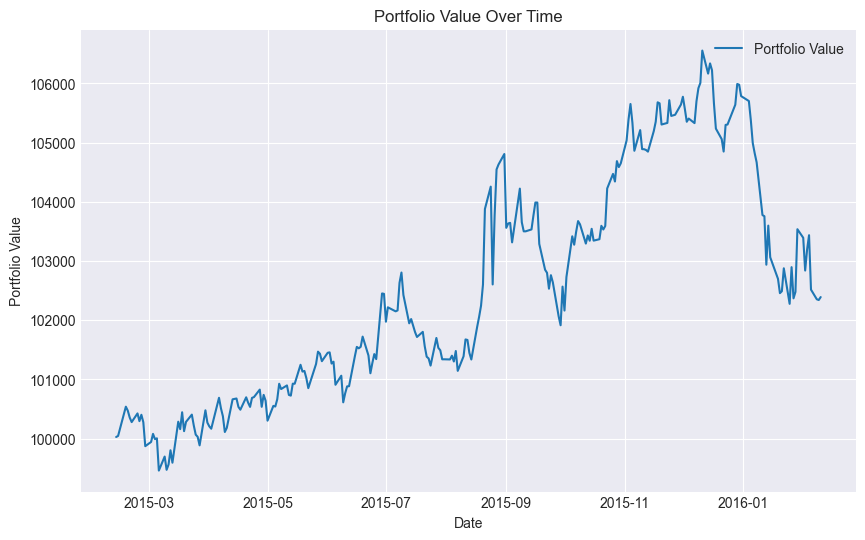

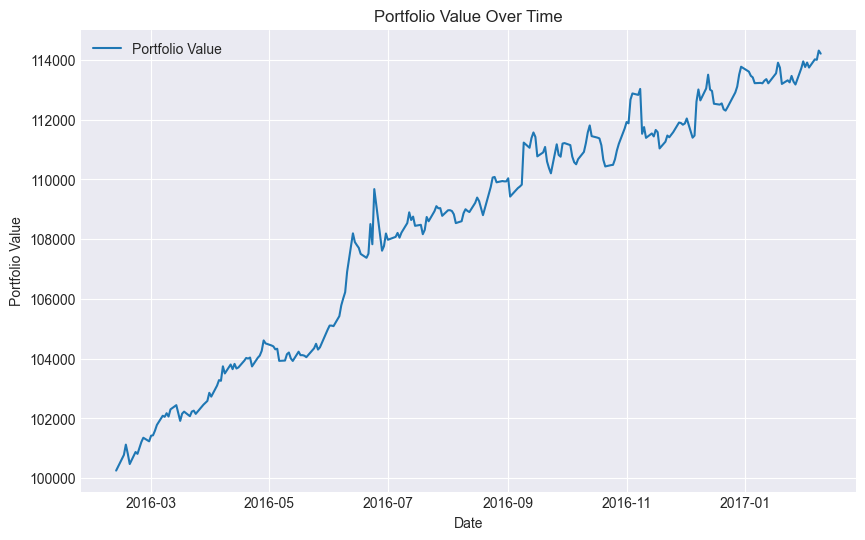

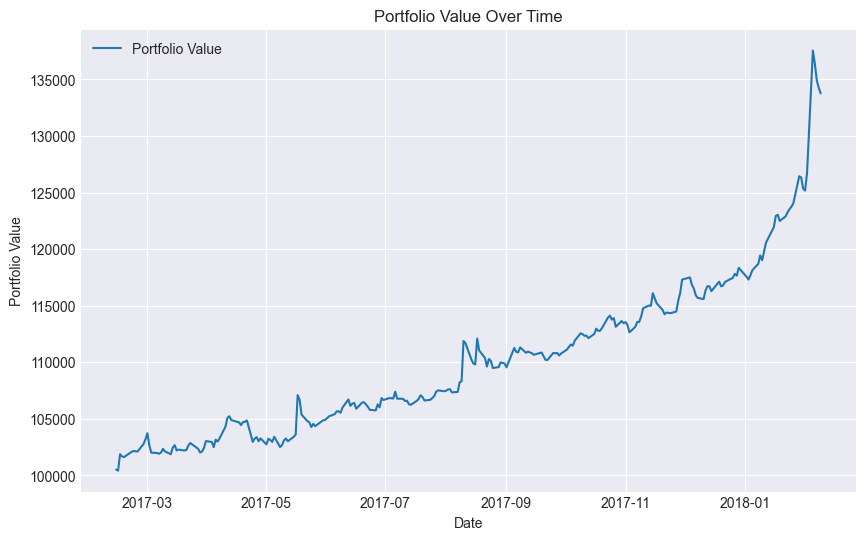

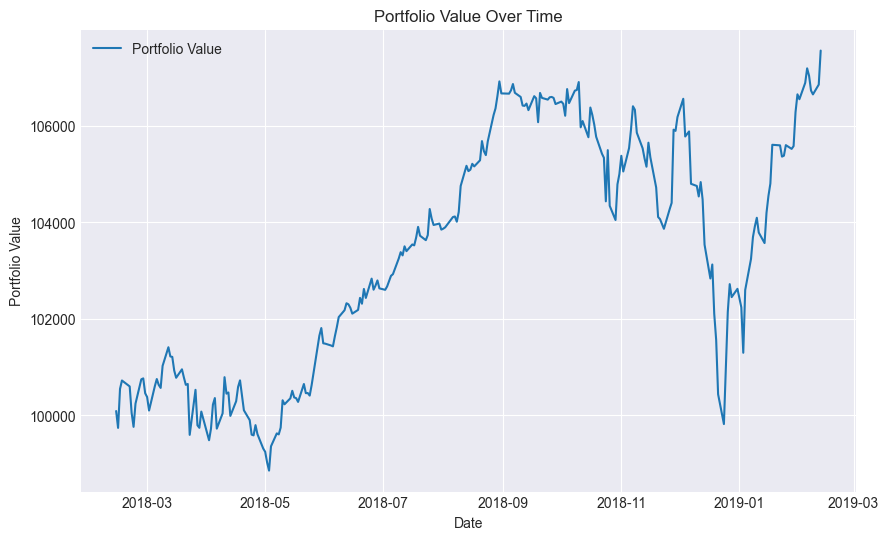

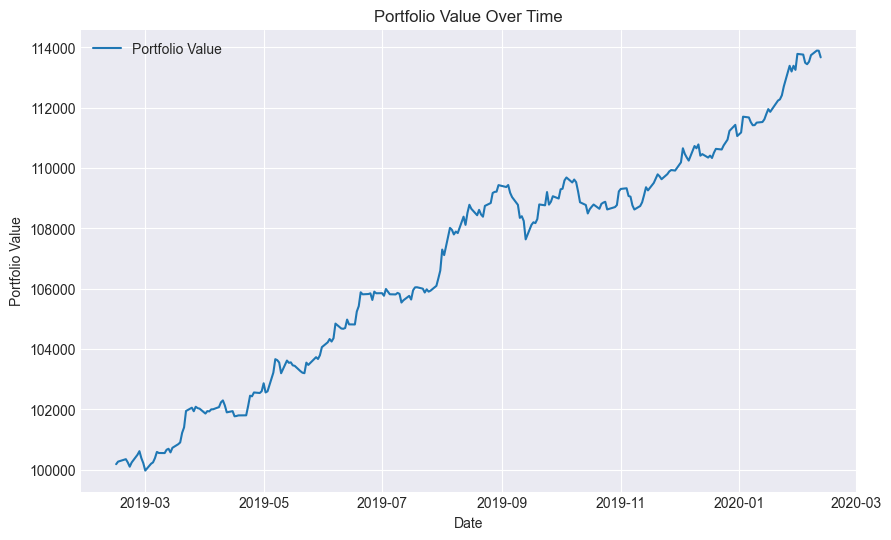

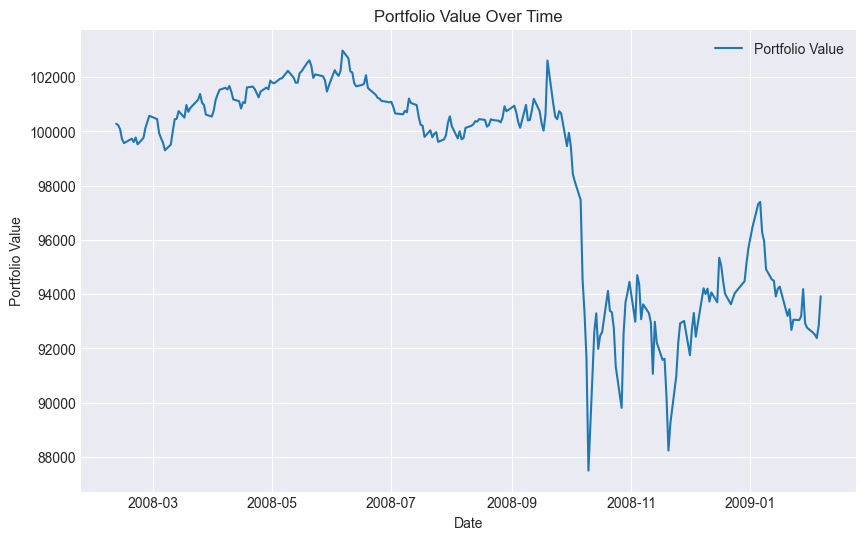

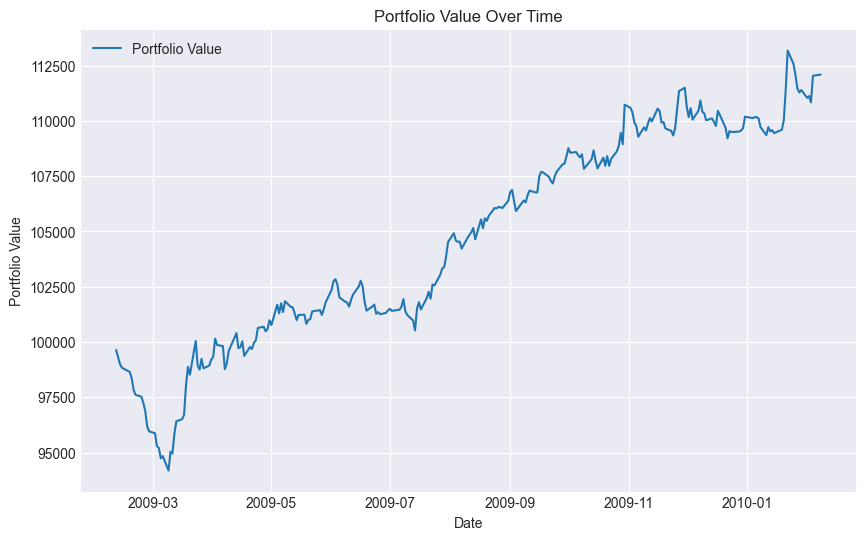

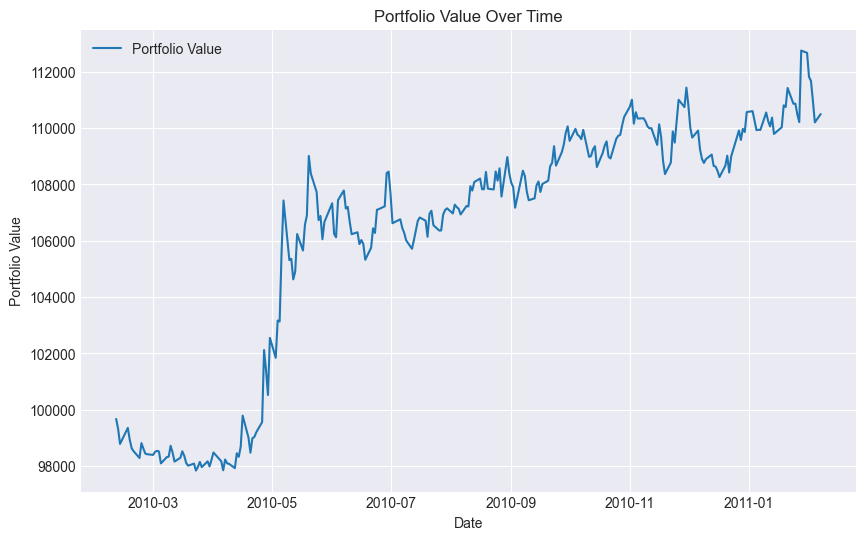

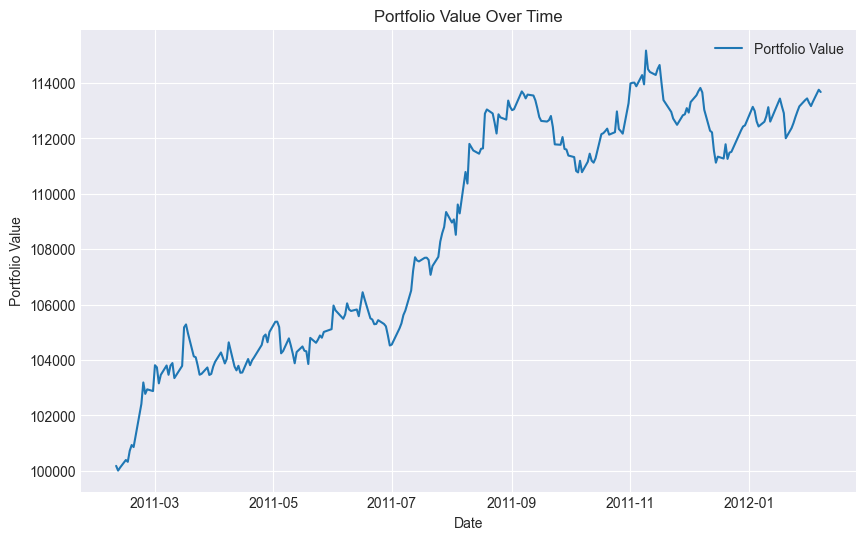

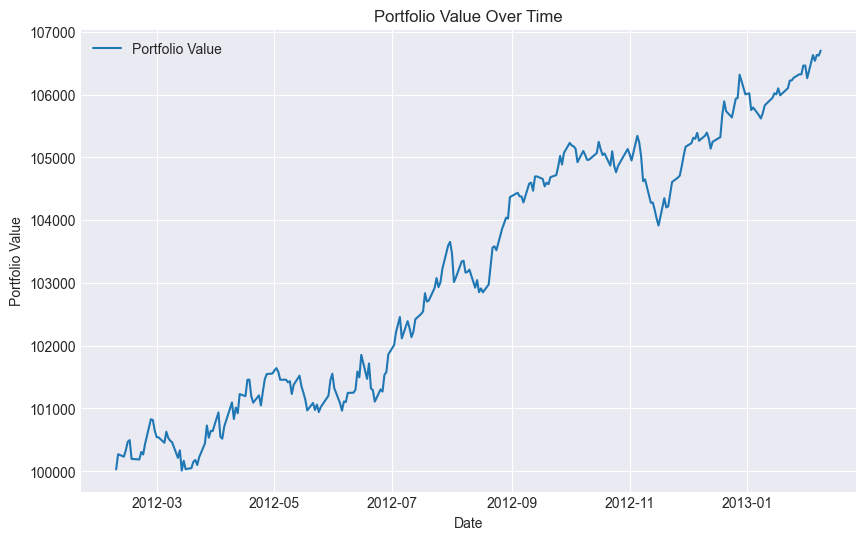

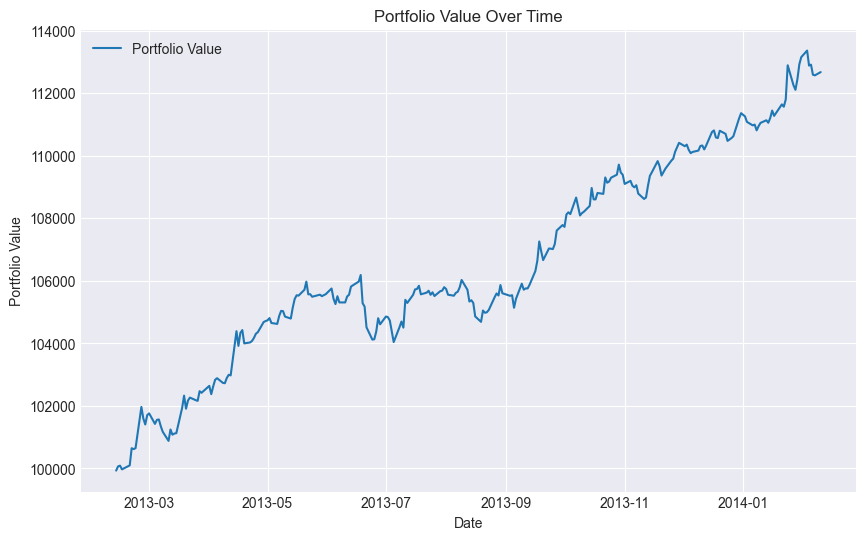

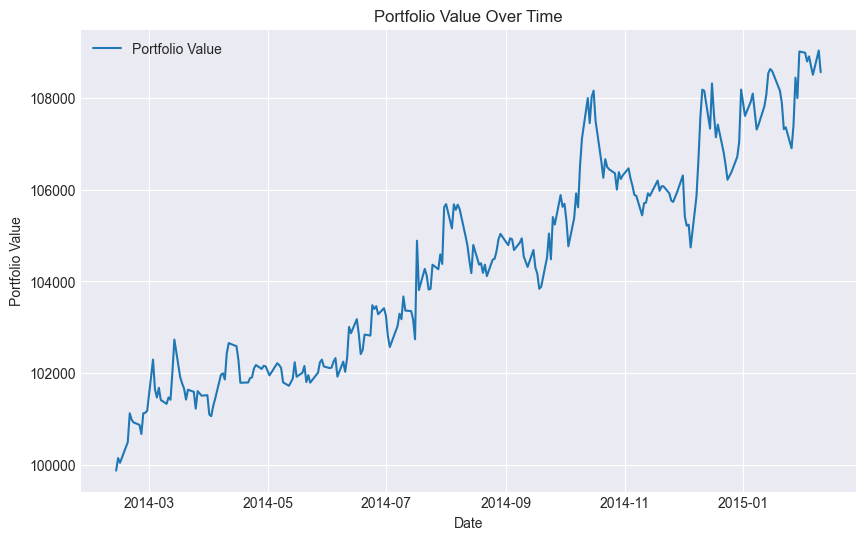

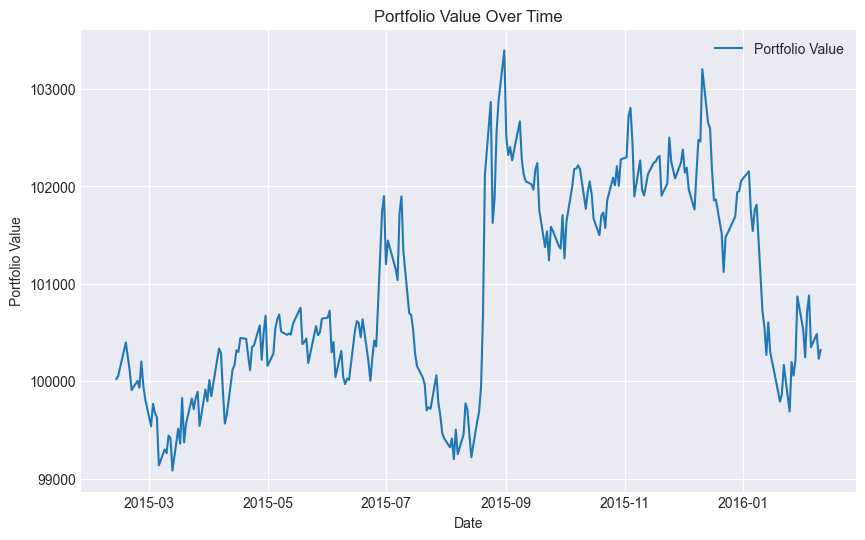

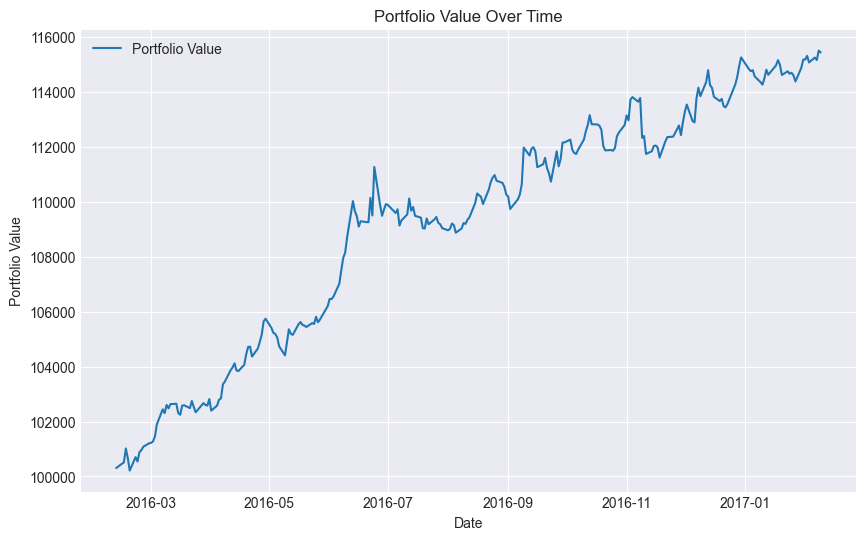

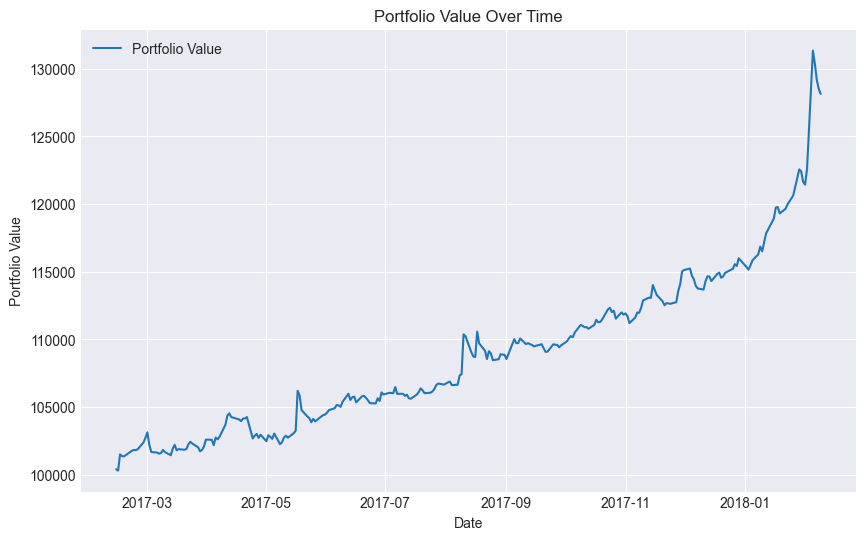

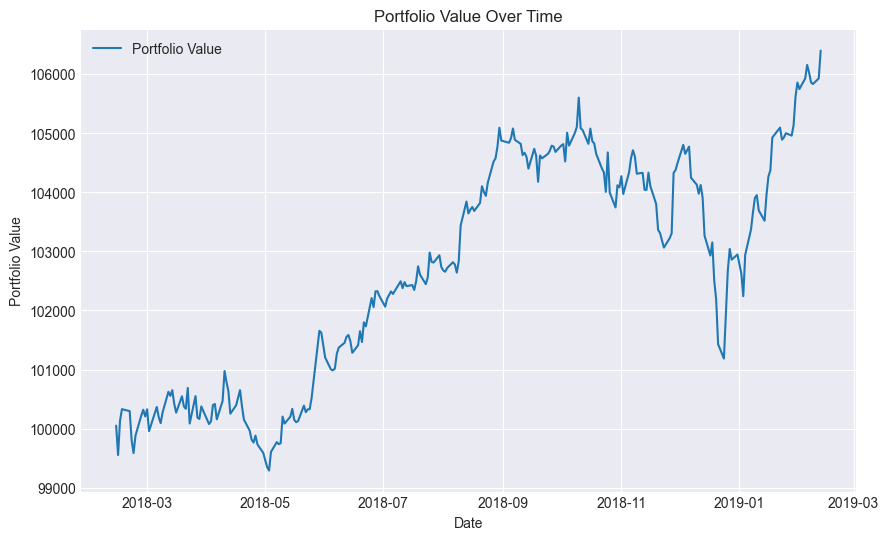

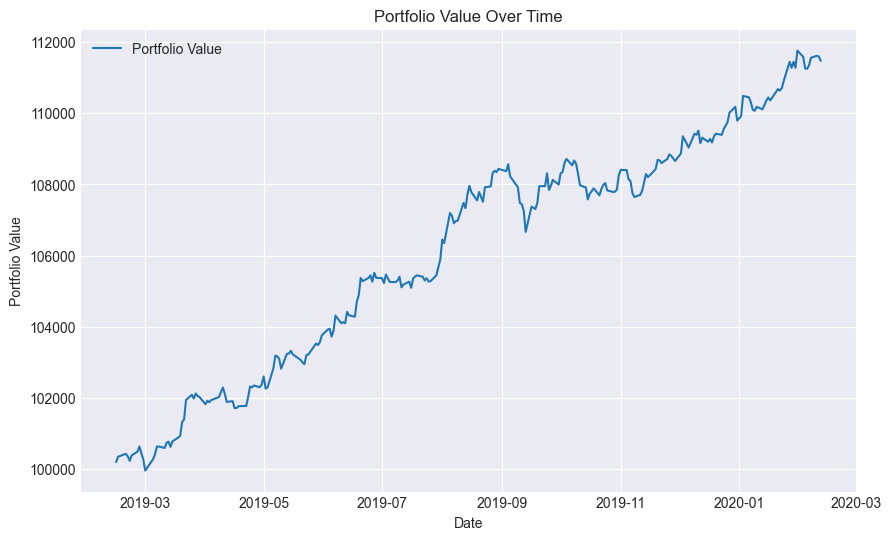

Mean-Variance Optimization Results: [{'train_period': (Timestamp('2006-02-06 00:00:00'), Timestamp('2008-02-07 00:00:00')), 'test_period': (Timestamp('2008-02-08 00:00:00'), Timestamp('2009-02-09 00:00:00')), 'metrics': {'Sharpe Ratio': -0.34713173079386983, 'Sortino Ratio': -0.43768011813615865, 'Max Drawdown': 0.14143062094034295}}, {'train_period': (Timestamp('2007-02-07 00:00:00'), Timestamp('2009-02-06 00:00:00')), 'test_period': (Timestamp('2009-02-09 00:00:00'), Timestamp('2010-02-09 00:00:00')), 'metrics': {'Sharpe Ratio': 0.9775115277881061, 'Sortino Ratio': 2.028809381603806, 'Max Drawdown': 0.030599096756928356}}, {'train_period': (Timestamp('2008-02-07 00:00:00'), Timestamp('2010-02-08 00:00:00')), 'test_period': (Timestamp('2010-02-09 00:00:00'), Timestamp('2011-02-08 00:00:00')), 'metrics': {'Sharpe Ratio': 1.0751005897014847, 'Sortino Ratio': 2.1164166900710515, 'Max Drawdown': 0.028929674525267218}}, {'train_period': (Timestamp('2009-02-06 00:00:00'), Timestamp('2011-02

In [12]:
# Define tickers and data parameters
tickers = ['VTI', 'AGG', 'DBC','^VIX']
data = get_data(tickers, '2006-01-01', '2021-01-04')
# Rolling validation with LSTM-based optimization (with periodic rebalancing)
lstm_results,lstm_values = generalized_rolling_validation(data, train_and_rebalance_portfolio)
print("LSTM Results:", lstm_results)
print("Final Portfolio Values:", lstm_values)
# Rolling validation with mean-variance optimization
mvo_results,mvo_values= generalized_rolling_validation(data, mean_variance_optimized_strategy)
# Rolling validation with maximum diversification optimization
md_results,md_values = generalized_rolling_validation(data, maximum_diversification)
print("Mean-Variance Optimization Results:", mvo_results)
print("Final Portfolio Values:", mvo_values)    


In [13]:
diff = [a - b for a, b in zip(lstm_values, mvo_values)]
print(diff)
print("Mean of the difference between LSTM and MVO:", np.mean(diff))
#average profit/average loss, a = final portfolio value for lstm, b = final value for mvo, starting cash = 100000
diff = [a - b for a, b in zip(lstm_values, md_values)]
print(diff)
print("Mean of the difference between LSTM and MD:", np.mean(diff))

# Calculate the average profit/average loss ratio
average_profit = np.mean([a - 100000 for a in lstm_values if a > 100000])
average_loss = 1
average_loss_calc = np.mean([100000 - b for b in mvo_values if b < 100000])
if average_loss_calc != 0:
    average_loss = average_loss_calc
profit_loss_ratio = average_profit / average_loss
print("LSTM profit/loss ratio:", profit_loss_ratio)

average_profit = np.mean([b - 100000 for b in mvo_values if b > 100000])
average_loss = 1
average_loss_calc = np.mean([100000 - b for b in mvo_values if b < 100000])
if average_loss_calc != 0:
    average_loss = average_loss_calc
profit_loss_ratio = average_profit / average_loss
print("MVO profit/loss ratio:", profit_loss_ratio)

average_profit = np.mean([b - 100000 for b in md_values if b > 100000])
average_loss = 1
average_loss_calc = np.mean([100000 - b for b in md_values if b < 100000])
if average_loss_calc != 0:
    average_loss = average_loss_calc
profit_loss_ratio = average_profit / average_loss
print("MD profit/loss ratio:", profit_loss_ratio)


[2574.2371617405734, 4235.545653378795, 10124.73600095058, 753.950859560282, -1205.2377595625148, 2163.953653072691, -7128.950968348145, -877.0655564820918, 9485.474618541673, 13424.637309286074, -1548.7782159124617, 6419.501653036175]
Mean of the difference between LSTM and MVO: 3201.8337007718023
[4135.786255044048, -8.3150152702583, 8138.422000833889, -1172.6572412321257, -1695.2026287858753, -3534.3413471554377, 1858.0502575664868, 1189.5905039115023, 8259.523409371293, 19052.65885503286, -387.91465800398146, 8615.96024592797]
Mean of the difference between LSTM and MD: 3704.296719770031
LSTM profit/loss ratio: 3.348386221552805
MVO profit/loss ratio: 2.6265249846245475
MD profit/loss ratio: 1.8846640366380751
